# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
      
    # TODO: Implement function and return a dataloader
    transform= transforms.Compose([transforms.Resize(image_size),transforms.CenterCrop(image_size),transforms.ToTensor()])
    #transform_1=transforms.ToTensor()
    
    celeb_images= datasets.ImageFolder(root= data_dir, transform=transform)
    
    train_loader= torch.utils.data.DataLoader(dataset=celeb_images,batch_size= batch_size, shuffle= True)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

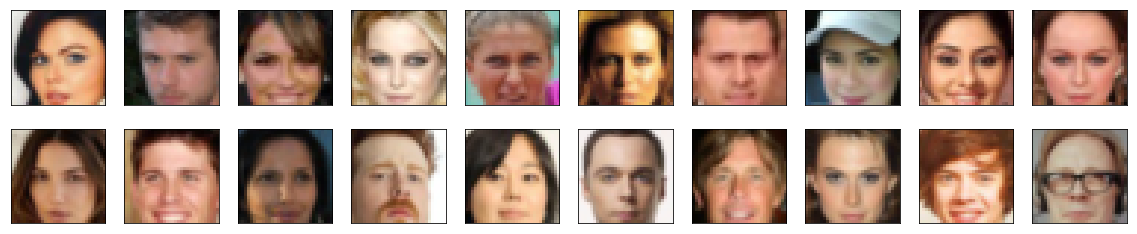

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min,max= feature_range
    x=x*(max-min)+min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9137)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
#Helper function for Discriminator class
def conv(in_channels, out_channels,kernel_size,stride=2, padding=1,batch_norm=True):
    #preparing to create a list of layers, creating an empty list named "layers"
    layers=[]
    
    #Bias is set to false so that the layers are not offset by any amount.
    conv_layer= nn.Conv2d(in_channels, out_channels,kernel_size, stride,padding,bias= False)
    
    #append conv_layer
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels ))
        
    #using sequential wrapper
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv_dim= conv_dim
        
        #32X 32 input
        self.conv1= conv(3,conv_dim,4,batch_norm= False) # no need for batch normalization in the first layer
        
        # 16x 16 output
        
        self.conv2= conv(conv_dim, conv_dim*2,4)
        
        # 8x8 output
        
        self.conv3= conv(conv_dim*2, conv_dim*4,4)
        #4X4 output
        
        # final fully conneected layer
        
        self.fc1= nn.Linear (conv_dim*4*4*4,1)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out= F.leaky_relu(self.conv1(x),0.2)
        out= F.leaky_relu(self.conv2(out),0.2)
        out= F.leaky_relu(self.conv3(out),0.2)
        
        #flatten the output layer
        out= out.view(-1,self.conv_dim*4*4*4)
        
        
        #final output layer
        
        out=self.fc1(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
#helper function for generator class( using De-convolutional layers)

def deconv(in_channels, out_channels, kernel_size,stride=2,padding=1,batch_norm=True):
    
    
    #create a sequence of transpose+optionoal batch norm layers
    layers= []
    transpose_conv_layer= nn.ConvTranspose2d (in_channels, out_channels, kernel_size,stride,padding, bias= False)
    

    #append transpose conv layer to the list of layers
    
    
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        #append batch_norm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
    

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim= conv_dim
        
        #first fully connected layer
        
        self.fc=nn.Linear(z_size,conv_dim*4*4*4 )
        
        #define transpose convolutional layers
        self.t_conv1= deconv(conv_dim*4, conv_dim*2,4 )
        self.t_conv2=deconv(conv_dim*2, conv_dim,4)
        self.t_conv3= deconv(conv_dim, 3,4,batch_norm=False) 
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out=self.fc(x)
        out= out.view(-1, self.conv_dim*4,4,4)
        
        #hidden transpose conv_layers+relu
        out= F.relu(self.t_conv1(out))
        out= F.relu(self.t_conv2(out))
        
        #last layers + tanh activation function
        out= self.t_conv3(out)
        out=F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    init_gain = 0.02
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, init_gain)

        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        nn.init.normal_(m.weight.data, 1.0, init_gain)
        nn.init.constant_(m.bias.data, 0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out,smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size= D_out.size(0)
    
    #Label smoothing
    if smooth:
        #smooth,real labels= 0.9
        labels= torch.ones(batch_size)*0.9
    else:
        labels= torch.ones(batch_size)
        
    if train_on_gpu:
        labels= labels.cuda()
        
    
    criterion= nn.BCEWithLogitsLoss()
    loss =  criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size =D_out.size(0)
    
    labels= torch.zeros(batch_size)
    
    if train_on_gpu:
        labels=labels.cuda()
    criterion=nn.BCEWithLogitsLoss()
    
    #calculate losses
    
    loss= criterion(D_out.squeeze(),labels)
    
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim


#params
lr= 0.0001
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1,beta2])   

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            
            #train with Real images
            
            if train_on_gpu:
                real_images=real_images.cuda()
            
            #train with real images
            D_real= D(real_images)
            d_real_loss= real_loss(D_real)
            
            #train with fake images
            
            #generate fake images
            z=np.random.uniform(-1,1,size=(batch_size,z_size))
            z=torch.from_numpy(z).float()
            
            #move to gpu
            if train_on_gpu:
                z = z.cuda()
                
            fake_images= G(z).detach()
            
            #compute discriminator loss on fake images
            
            D_fake= D(fake_images)
            d_fake_loss=fake_loss(D_fake)
            
            #add losses and perform backpropagation      
            
                       
            d_loss = d_real_loss+d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            
            #train with generated fake images and flipped labels
            
            #Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()

            if train_on_gpu:
                z = z.cuda()
                
            fake_images=G(z)
            
            #compute the discriminator losses on fake images
            
            D_fake= D(fake_images)
            g_loss= real_loss(D_fake)
            
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.3337 | g_loss: 0.9832
Epoch [    1/   50] | d_loss: 0.1843 | g_loss: 2.4064
Epoch [    1/   50] | d_loss: 0.1455 | g_loss: 3.3876
Epoch [    1/   50] | d_loss: 0.1180 | g_loss: 3.6123
Epoch [    1/   50] | d_loss: 0.1171 | g_loss: 3.8897
Epoch [    1/   50] | d_loss: 0.6712 | g_loss: 6.5065
Epoch [    1/   50] | d_loss: 0.3207 | g_loss: 2.5253
Epoch [    1/   50] | d_loss: 0.2707 | g_loss: 2.2059
Epoch [    1/   50] | d_loss: 0.3740 | g_loss: 2.5828
Epoch [    1/   50] | d_loss: 0.4351 | g_loss: 2.0575
Epoch [    1/   50] | d_loss: 0.6156 | g_loss: 1.1611
Epoch [    1/   50] | d_loss: 0.5609 | g_loss: 1.5756
Epoch [    1/   50] | d_loss: 0.5214 | g_loss: 2.0773
Epoch [    1/   50] | d_loss: 0.7108 | g_loss: 3.1345
Epoch [    1/   50] | d_loss: 0.5981 | g_loss: 1.6108
Epoch [    1/   50] | d_loss: 0.5948 | g_loss: 1.5516
Epoch [    1/   50] | d_loss: 0.5908 | g_loss: 1.4309
Epoch [    1/   50] | d_loss: 0.7359 | g_loss: 2.3683
Epoch [    1/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.8327 | g_loss: 1.8163
Epoch [    6/   50] | d_loss: 0.6069 | g_loss: 1.2426
Epoch [    6/   50] | d_loss: 0.7528 | g_loss: 1.3727
Epoch [    6/   50] | d_loss: 0.7008 | g_loss: 1.0901
Epoch [    6/   50] | d_loss: 0.7964 | g_loss: 1.8969
Epoch [    6/   50] | d_loss: 0.6930 | g_loss: 1.4498
Epoch [    6/   50] | d_loss: 0.7762 | g_loss: 1.0116
Epoch [    6/   50] | d_loss: 0.6145 | g_loss: 1.7596
Epoch [    6/   50] | d_loss: 0.8126 | g_loss: 1.5910
Epoch [    6/   50] | d_loss: 0.6981 | g_loss: 1.4409
Epoch [    6/   50] | d_loss: 0.6135 | g_loss: 1.4279
Epoch [    6/   50] | d_loss: 0.4270 | g_loss: 1.6829
Epoch [    6/   50] | d_loss: 0.5788 | g_loss: 2.0075
Epoch [    6/   50] | d_loss: 0.8374 | g_loss: 1.2072
Epoch [    6/   50] | d_loss: 0.5321 | g_loss: 1.7683
Epoch [    6/   50] | d_loss: 0.7147 | g_loss: 1.2640
Epoch [    6/   50] | d_loss: 0.5589 | g_loss: 1.0717
Epoch [    6/   50] | d_loss: 0.7018 | g_loss: 1.6219
Epoch [    6/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.5241 | g_loss: 2.5044
Epoch [   11/   50] | d_loss: 0.2723 | g_loss: 1.7777
Epoch [   11/   50] | d_loss: 0.4640 | g_loss: 2.3429
Epoch [   11/   50] | d_loss: 0.4488 | g_loss: 1.7547
Epoch [   11/   50] | d_loss: 0.5507 | g_loss: 2.1678
Epoch [   11/   50] | d_loss: 0.2929 | g_loss: 2.1908
Epoch [   11/   50] | d_loss: 0.8696 | g_loss: 3.5046
Epoch [   11/   50] | d_loss: 0.4260 | g_loss: 1.9635
Epoch [   11/   50] | d_loss: 1.2334 | g_loss: 3.6145
Epoch [   11/   50] | d_loss: 0.6774 | g_loss: 1.3649
Epoch [   11/   50] | d_loss: 0.5738 | g_loss: 1.5405
Epoch [   11/   50] | d_loss: 0.4958 | g_loss: 2.0510
Epoch [   11/   50] | d_loss: 0.6118 | g_loss: 2.5371
Epoch [   11/   50] | d_loss: 0.6836 | g_loss: 1.8798
Epoch [   11/   50] | d_loss: 0.6430 | g_loss: 1.5484
Epoch [   12/   50] | d_loss: 0.5581 | g_loss: 1.7354
Epoch [   12/   50] | d_loss: 0.2887 | g_loss: 2.7009
Epoch [   12/   50] | d_loss: 0.5823 | g_loss: 1.4546
Epoch [   12/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.3771 | g_loss: 2.9902
Epoch [   16/   50] | d_loss: 0.4921 | g_loss: 1.9715
Epoch [   16/   50] | d_loss: 0.6450 | g_loss: 3.2603
Epoch [   16/   50] | d_loss: 0.4570 | g_loss: 1.3206
Epoch [   16/   50] | d_loss: 0.3989 | g_loss: 2.1135
Epoch [   16/   50] | d_loss: 0.3523 | g_loss: 2.1292
Epoch [   16/   50] | d_loss: 0.9005 | g_loss: 1.0792
Epoch [   16/   50] | d_loss: 0.2752 | g_loss: 2.2688
Epoch [   17/   50] | d_loss: 0.4192 | g_loss: 2.5212
Epoch [   17/   50] | d_loss: 0.8096 | g_loss: 2.0683
Epoch [   17/   50] | d_loss: 0.4418 | g_loss: 1.9803
Epoch [   17/   50] | d_loss: 0.6874 | g_loss: 1.2056
Epoch [   17/   50] | d_loss: 0.4937 | g_loss: 1.6262
Epoch [   17/   50] | d_loss: 0.2850 | g_loss: 2.2390
Epoch [   17/   50] | d_loss: 0.4228 | g_loss: 2.1798
Epoch [   17/   50] | d_loss: 0.6879 | g_loss: 1.7780
Epoch [   17/   50] | d_loss: 0.2278 | g_loss: 2.3189
Epoch [   17/   50] | d_loss: 0.4845 | g_loss: 1.7297
Epoch [   17/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.4096 | g_loss: 2.8513
Epoch [   22/   50] | d_loss: 0.2943 | g_loss: 2.0106
Epoch [   22/   50] | d_loss: 0.1948 | g_loss: 2.8299
Epoch [   22/   50] | d_loss: 0.5367 | g_loss: 2.2621
Epoch [   22/   50] | d_loss: 0.2038 | g_loss: 2.8280
Epoch [   22/   50] | d_loss: 0.4181 | g_loss: 1.9572
Epoch [   22/   50] | d_loss: 0.3083 | g_loss: 2.8092
Epoch [   22/   50] | d_loss: 0.4871 | g_loss: 3.3450
Epoch [   22/   50] | d_loss: 0.3808 | g_loss: 2.3320
Epoch [   22/   50] | d_loss: 0.3795 | g_loss: 3.1846
Epoch [   22/   50] | d_loss: 0.2658 | g_loss: 3.0008
Epoch [   22/   50] | d_loss: 0.2186 | g_loss: 2.1107
Epoch [   22/   50] | d_loss: 0.2593 | g_loss: 3.3359
Epoch [   22/   50] | d_loss: 0.2661 | g_loss: 3.5383
Epoch [   22/   50] | d_loss: 0.3249 | g_loss: 2.7857
Epoch [   22/   50] | d_loss: 0.1875 | g_loss: 2.0861
Epoch [   22/   50] | d_loss: 0.3308 | g_loss: 2.1263
Epoch [   22/   50] | d_loss: 0.3719 | g_loss: 3.2141
Epoch [   22/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.2848 | g_loss: 2.9210
Epoch [   27/   50] | d_loss: 0.1925 | g_loss: 2.5120
Epoch [   27/   50] | d_loss: 0.2842 | g_loss: 4.0055
Epoch [   27/   50] | d_loss: 0.3942 | g_loss: 2.1424
Epoch [   27/   50] | d_loss: 0.2316 | g_loss: 3.3366
Epoch [   27/   50] | d_loss: 0.2165 | g_loss: 3.9334
Epoch [   27/   50] | d_loss: 0.5117 | g_loss: 3.7479
Epoch [   27/   50] | d_loss: 0.1954 | g_loss: 4.2595
Epoch [   27/   50] | d_loss: 0.1643 | g_loss: 2.9773
Epoch [   27/   50] | d_loss: 0.1513 | g_loss: 2.6705
Epoch [   27/   50] | d_loss: 0.1615 | g_loss: 2.6298
Epoch [   27/   50] | d_loss: 0.2540 | g_loss: 3.0804
Epoch [   27/   50] | d_loss: 0.1388 | g_loss: 3.3344
Epoch [   27/   50] | d_loss: 0.2063 | g_loss: 2.2555
Epoch [   27/   50] | d_loss: 0.3311 | g_loss: 2.7919
Epoch [   27/   50] | d_loss: 0.2499 | g_loss: 3.8635
Epoch [   27/   50] | d_loss: 0.2940 | g_loss: 3.2777
Epoch [   27/   50] | d_loss: 0.3259 | g_loss: 2.9951
Epoch [   27/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.1520 | g_loss: 3.7749
Epoch [   32/   50] | d_loss: 0.2675 | g_loss: 3.9777
Epoch [   32/   50] | d_loss: 0.3183 | g_loss: 4.1774
Epoch [   32/   50] | d_loss: 0.1434 | g_loss: 2.8116
Epoch [   32/   50] | d_loss: 0.1721 | g_loss: 2.7062
Epoch [   32/   50] | d_loss: 0.2299 | g_loss: 3.7004
Epoch [   32/   50] | d_loss: 0.2345 | g_loss: 3.5493
Epoch [   32/   50] | d_loss: 0.1482 | g_loss: 4.0812
Epoch [   32/   50] | d_loss: 0.1123 | g_loss: 3.4415
Epoch [   32/   50] | d_loss: 0.4122 | g_loss: 1.5126
Epoch [   32/   50] | d_loss: 0.1723 | g_loss: 3.4766
Epoch [   32/   50] | d_loss: 0.2410 | g_loss: 3.0807
Epoch [   32/   50] | d_loss: 0.0955 | g_loss: 3.6255
Epoch [   32/   50] | d_loss: 0.1453 | g_loss: 2.5769
Epoch [   32/   50] | d_loss: 0.3253 | g_loss: 2.6281
Epoch [   32/   50] | d_loss: 0.2337 | g_loss: 2.4583
Epoch [   33/   50] | d_loss: 1.0538 | g_loss: 6.3990
Epoch [   33/   50] | d_loss: 0.2183 | g_loss: 4.0199
Epoch [   33/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.1481 | g_loss: 3.6944
Epoch [   37/   50] | d_loss: 0.1272 | g_loss: 3.0180
Epoch [   37/   50] | d_loss: 0.2603 | g_loss: 4.0207
Epoch [   37/   50] | d_loss: 0.1431 | g_loss: 4.2044
Epoch [   37/   50] | d_loss: 0.8552 | g_loss: 1.4161
Epoch [   37/   50] | d_loss: 0.2272 | g_loss: 2.8037
Epoch [   37/   50] | d_loss: 0.1607 | g_loss: 3.1646
Epoch [   37/   50] | d_loss: 0.2718 | g_loss: 3.4085
Epoch [   37/   50] | d_loss: 0.1977 | g_loss: 3.4995
Epoch [   38/   50] | d_loss: 0.4847 | g_loss: 5.7982
Epoch [   38/   50] | d_loss: 0.1416 | g_loss: 4.2524
Epoch [   38/   50] | d_loss: 0.2269 | g_loss: 3.2009
Epoch [   38/   50] | d_loss: 0.2434 | g_loss: 4.0603
Epoch [   38/   50] | d_loss: 0.1528 | g_loss: 4.1093
Epoch [   38/   50] | d_loss: 0.2352 | g_loss: 3.4000
Epoch [   38/   50] | d_loss: 0.1782 | g_loss: 3.3219
Epoch [   38/   50] | d_loss: 0.0937 | g_loss: 4.9153
Epoch [   38/   50] | d_loss: 0.3000 | g_loss: 1.6486
Epoch [   38/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.1280 | g_loss: 3.5952
Epoch [   42/   50] | d_loss: 0.1119 | g_loss: 3.3537
Epoch [   43/   50] | d_loss: 0.2269 | g_loss: 3.1294
Epoch [   43/   50] | d_loss: 0.1392 | g_loss: 3.1823
Epoch [   43/   50] | d_loss: 1.3282 | g_loss: 2.9261
Epoch [   43/   50] | d_loss: 0.2755 | g_loss: 3.3478
Epoch [   43/   50] | d_loss: 0.1202 | g_loss: 2.3094
Epoch [   43/   50] | d_loss: 0.0996 | g_loss: 4.9639
Epoch [   43/   50] | d_loss: 0.1184 | g_loss: 3.8523
Epoch [   43/   50] | d_loss: 0.0980 | g_loss: 3.9965
Epoch [   43/   50] | d_loss: 1.1318 | g_loss: 2.4456
Epoch [   43/   50] | d_loss: 0.5935 | g_loss: 4.8689
Epoch [   43/   50] | d_loss: 0.0779 | g_loss: 4.0712
Epoch [   43/   50] | d_loss: 0.4356 | g_loss: 2.1690
Epoch [   43/   50] | d_loss: 0.1707 | g_loss: 3.5906
Epoch [   43/   50] | d_loss: 0.1910 | g_loss: 2.9198
Epoch [   43/   50] | d_loss: 0.0466 | g_loss: 4.0003
Epoch [   43/   50] | d_loss: 0.1521 | g_loss: 3.9987
Epoch [   43/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.1111 | g_loss: 4.3250
Epoch [   48/   50] | d_loss: 0.1369 | g_loss: 2.6492
Epoch [   48/   50] | d_loss: 0.5407 | g_loss: 3.1419
Epoch [   48/   50] | d_loss: 0.1415 | g_loss: 3.9792
Epoch [   48/   50] | d_loss: 0.1455 | g_loss: 3.1102
Epoch [   48/   50] | d_loss: 0.1179 | g_loss: 3.8600
Epoch [   48/   50] | d_loss: 0.2278 | g_loss: 4.0903
Epoch [   48/   50] | d_loss: 0.0772 | g_loss: 4.5667
Epoch [   48/   50] | d_loss: 0.1647 | g_loss: 3.2947
Epoch [   48/   50] | d_loss: 0.3198 | g_loss: 3.2604
Epoch [   48/   50] | d_loss: 0.1879 | g_loss: 2.9427
Epoch [   48/   50] | d_loss: 0.1255 | g_loss: 3.4103
Epoch [   48/   50] | d_loss: 0.0797 | g_loss: 3.8619
Epoch [   48/   50] | d_loss: 0.1068 | g_loss: 3.1106
Epoch [   48/   50] | d_loss: 0.1196 | g_loss: 4.3101
Epoch [   48/   50] | d_loss: 0.3223 | g_loss: 5.3400
Epoch [   48/   50] | d_loss: 0.1131 | g_loss: 4.7350
Epoch [   48/   50] | d_loss: 0.1247 | g_loss: 2.6920
Epoch [   48/   50] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

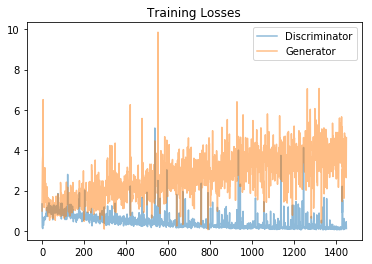

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

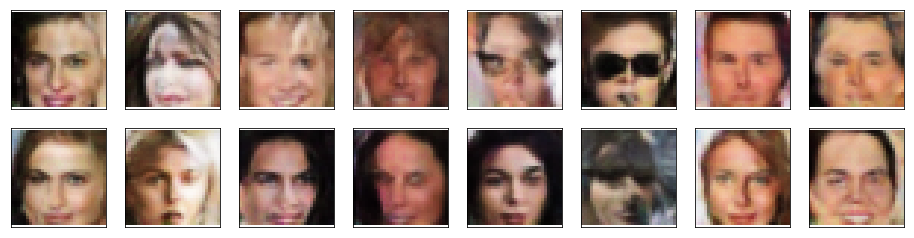

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

1. As noted above, the dataset is biased, the images generated are mostly white. Adding more diverse inputs, helps to generate diverse outputs.

2. The input image resolution is not so good, so that can be improved.

3. Can be attempted to train for more epochs to generate better images.

4. Data Augmentation can be tried by rotating the image to minute degrees. We can use different optimizer, SGD for discriminator, Adam for generator.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.